In [ ]:
import math
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
sb.set_style("whitegrid")

On travaille avec la fonction
$$f(x) = 3x^2+4x+5$$

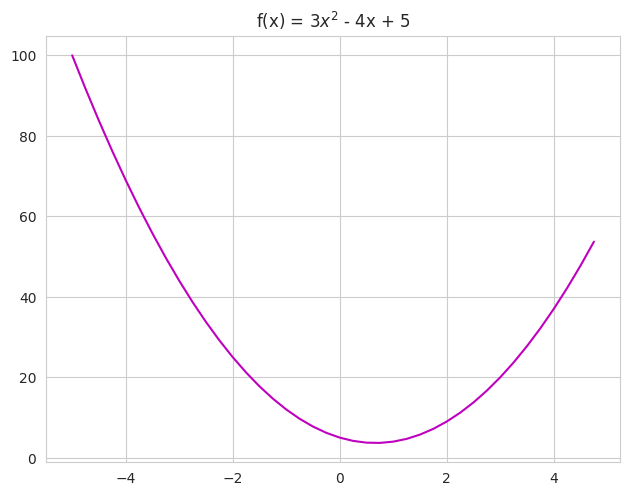

In [ ]:
def f(x):
    return 3*x**2 - 4*x + 5

xs = np.arange(-5,5, 0.25) # Domaine
ys = f(xs) # Image

plt.plot(xs,ys,c="m", label=r"f(x) = 3$x^2$ - 4x + 5")
plt.tight_layout()
plt.title(r"f(x) = 3$x^2$ - 4x + 5")
plt.show()



La définition de la dérivé est
$$\frac{d}{dx}f(x) = \lim_{h \to 0} \frac{f(x+h) - f(x)}{h}$$

L'approximation linéaire de la droite tangente au point $(x,y)$ est $$L(x) \approx f(a) + \frac{d}{dx}f(a) (x - a)$$

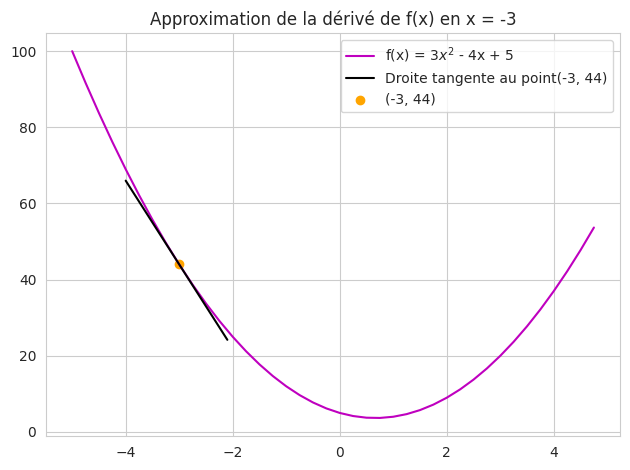

In [ ]:
def approximation_dérivé(fonction, x: float, h = 0.001) -> float:
    """Calcule l'approximation de la dérivé de fonction évalué en x"""
    return (fonction(x+h) - fonction(x)) /h

def approximation_droite_tangente(fonction, a: float, x: np.ndarray, h = 0.001) -> np.ndarray:
    """ # Arguments
    - fonction: f(x)
    - a: Le point où on calcule la dérivé
    - x: Le domaine où sera évaluer la droite
    """
    y = fonction(a)
    pente = approximation_dérivé(fonction, a, h)
    return pente * (x - a) + y

xs = np.arange(-5,5, 0.25) # Domaine
ys = f(xs) # Image

h = 0.001
x = -3
y = f(x)
pente = approximation_dérivé(f, x, h)

xs_tangent = np.arange(x-1, x+1,0.1)
ys_tangente = pente * (xs_tangent - x) + y
ys_tangente = approximation_droite_tangente(f, x, xs_tangent)

plt.plot(xs,ys,c="m", label=r"f(x) = 3$x^2$ - 4x + 5")
plt.plot(xs_tangent, ys_tangente, c="black", label=f"Droite tangente au point{(x, y)}")

plt.title(f"Approximation de la dérivé de f(x) en x = {x}")
plt.scatter(x,y,c="orange",label=(f"{(x,y)}"))
plt.legend()
plt.tight_layout()
plt.show()

On peut généraliser la dérivé d'une variable en gardant les autres variables constantes, soit le vecteur $\textbf{x} = \begin{pmatrix} x_1 & x_2 & x_3\end{pmatrix}^\top$. On définie la dérivé partielle de $f(\textbf{x})$ par rapport à $x_1$ comme

$$\frac{\partial}{\partial x_1}f(\textbf{x}) = \lim_{h \to 0} \frac{f(x_1+h, x_2, x_3) - f(x_1, x_2, x_3)}{h}$$


In [ ]:
def approximation_dérivé_partielle(fonction, x: np.ndarray, indice: int,  h = 0.001) -> float:
    """Calcule l'approximation de la dérivée de la fonction évalué en x"""
    if indice >= x.shape[0] or indice < 0:
         raise ValueError(f"Indice hors limite")
    x = x.copy()
    f_x = fonction(x)
    x[indice] = x[indice] + h
    return (fonction(x) - f_x) / h


On travaille à présent avec
$$f(x_1, x_2, x_3) = x_1x_2 + x_3$$

In [ ]:

x1, x2 , x3 = 2, - 3, 10
x = np.array((x1, x2, x3), dtype=float)
def f(x):
    return x[0]*x[1] + x[2]
print(f"La fonction évaluée en x est {f(x)}")
print(f"La dérivé partielle par rapport à x1 est {approximation_dérivé_partielle(f,x,0)}")
print(f"La dérivé partielle par rapport à x2 est {approximation_dérivé_partielle(f,x,1)}")
print(f"La dérivé partielle par rapport à x3 est {approximation_dérivé_partielle(f,x,2)}")

La fonction évaluée en x est 4.0
La dérivé partielle par rapport à x1 est -3.0000000000001137
La dérivé partielle par rapport à x2 est 1.9999999999997797
La dérivé partielle par rapport à x3 est 0.9999999999994458


On créer notre objet *Valeur*

In [ ]:
class Valeur:

    def __init__(self, données, enfants = (), op='', nom='', racine=False):
        self.données = données
        self.grad = 0.0
        self.anciens = set(enfants)
        self.op = op
        self.nom = nom
        self.rétropropagation = lambda: None
        self.racine = racine

    def __repr__(self):
        return f"Valeur(données = {self.données})"

    def __add__(self, autre):
        autre = autre if isinstance(autre, Valeur) else Valeur(autre)
        retour = Valeur(self.données + autre.données, (self, autre), '+')

        def rétro():
          self.grad += 1.0 * retour.grad
          autre.grad += 1.0 * retour.grad
        retour.rétropropagation = rétro
        return retour

    def __mul__(self, autre):
        autre = autre if isinstance(autre, Valeur) else Valeur(autre)
        retour = Valeur(self.données * autre.données, (self, autre), '*')

        def rétro():
          self.grad += autre.données * retour.grad
          autre.grad += self.données * retour.grad

        retour.rétropropagation = rétro
        return retour

    def __neg__(self):
      return self * -1

    def __sub__(self, autre):
      return self + (-autre)

    def __radd__(self, autre):
      return self + autre

    def __rsub__(self, autre):
      return Valeur(autre) + (-self)

    def __rmul__(self, autre):
      return self * autre

    def __truediv__(self, autre):
      return self * autre ** -1

    def __rtruediv__(self, autre):
        return autre * self**-1

    def __pow__(self, autre):
      assert isinstance(autre, (int,float))
      retour = Valeur(self.données ** autre, (self, ), f'**{autre}')

      def rétro():
        self.grad += autre * self.données ** (autre - 1) * retour.grad
      retour.rétropropagation = rétro
      return retour

    def exp(self):
      x = self.données
      retour = Valeur(math.exp(x), (self,), 'exp')

      def rétro():
        self.grad += retour.données * retour.grad

      retour.rétropropagation = rétro

      return retour

    def tanh(self):
      x = self.données
      t = (math.exp(2*x) - 1) / (math.exp(2*x) + 1)
      retour = Valeur(t, (self, ), 'tanh')

      def rétro():
        self.grad += (1 - t**2) * retour.grad

      retour.rétropropagation = rétro
      return retour


    def calcule_grad(self):
      if not self.racine:
        raise ValueError ("Doit être appelé par la racine")

      self.grad = 1.0

      liste = []
      visités = set()
      def trie_topologique(n):
          if n not in visités:
            visités.add(n)
            for enfant in n.anciens:
                trie_topologique(enfant)

            liste.append(n)

      trie_topologique(self)

      for n in reversed(liste):
        n.rétropropagation()


In [ ]:
x_1 = Valeur(2.0, nom = 'x_1')
x_2 = Valeur(-3.0, nom = 'x_2')
x_3 = x_1*x_2; x_3.nom = 'x_3'
x_4 = Valeur(10.0, nom = 'x_4')
x_5 = x_3 + x_4; x_5.nom = 'x_5'
x_6 = Valeur(-2.0, nom = 'x_6')

L = x_5 * x_6 ; L.nom = 'L'; L.racine = True
print(L.anciens)

{Valeur(données = 4.0), Valeur(données = -2.0)}


In [ ]:
1- x_1

Valeur(données = -1.0)

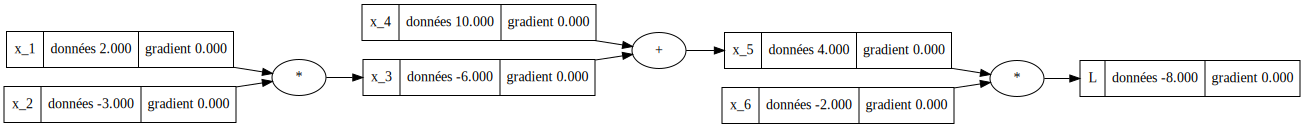

In [ ]:
from graphviz import Digraph
def trace(racine: Valeur) -> tuple[set[Valeur], tuple[set[Valeur],set[Valeur]]]:
    """Construit un ensemble de tout les noeuds et arcs d'un graphe"""
    noeuds, arcs = set(), set()

    def construire(val: Valeur):
        if val not in noeuds:
            noeuds.add(val)
            for enf in val.anciens:
                arcs.add((enf, val))
                construire(enf)
    construire(racine)
    return noeuds, arcs

def dessine_graphe(racine):
    d = Digraph(format='svg', graph_attr={'rankdir': 'LR'})

    noeuds, arcs = trace(racine)
    for n in noeuds:
        uid = str(id(n))
        # Pour toute les Valeurs dans le grapge, creér un noeud rectangle
        d.node(name= uid, label= "{%s | données %.3f | gradient % .3f}" % (n.nom, n.données, n.grad), shape='record')

        if n.op:
            # Si la Valeur est obtenue par une opération d'autres Valeurs, creér un noeud op
            d.node(name=uid + n.op, label = n.op)
            # Connecte le noeud
            d.edge(uid + n.op, uid)
    for n1, n2 in arcs:
        # Connete n1
        d.edge(str(id(n1)), str(id(n2)) + n2.op)

    return d


dessine_graphe(L)

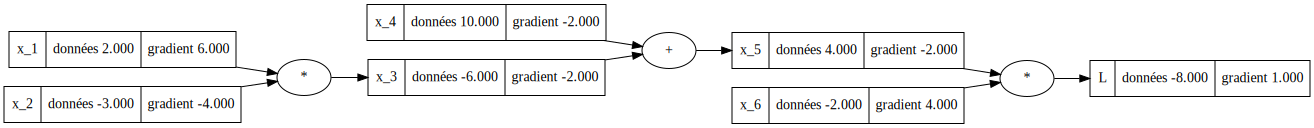

In [ ]:
L.calcule_grad()
dessine_graphe(L)

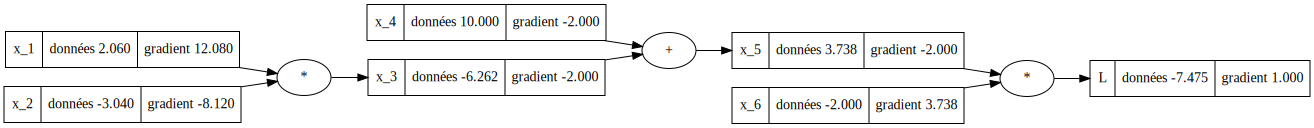

In [ ]:
x_1.données += 0.01 *  x_1.grad
x_2.données += 0.01 *  x_2.grad

x_3 = x_1*x_2; x_3.nom = 'x_3'
x_4 = Valeur(10.0, nom = 'x_4')
x_5 = x_3 + x_4; x_5.nom = 'x_5'
x_6 = Valeur(-2.0, nom = 'x_6')

L = x_5 * x_6 ; L.nom = 'L'; L.racine = True
L.calcule_grad()
dessine_graphe(L)

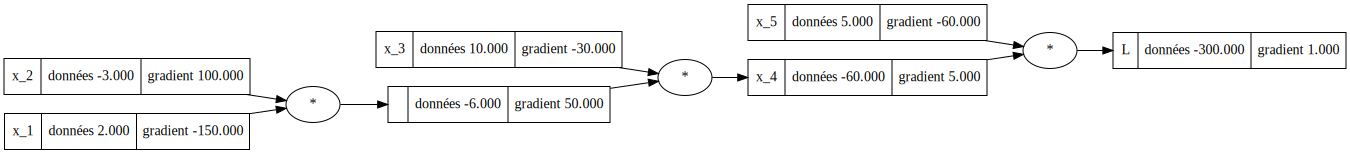

In [ ]:
x_1 = Valeur(2.0, nom = 'x_1')
x_2 = Valeur(-3.0, nom = 'x_2')
x_3 = Valeur(10.0, nom = 'x_3')
x_4 = x_1*x_2*x_3; x_4.nom = 'x_4'

x_5 = Valeur(5, nom = 'x_5')

L = x_5 * x_4 ; L.nom = 'L'; L.racine = True
L.calcule_grad()
dessine_graphe(L)

# Exemple avec un neurones

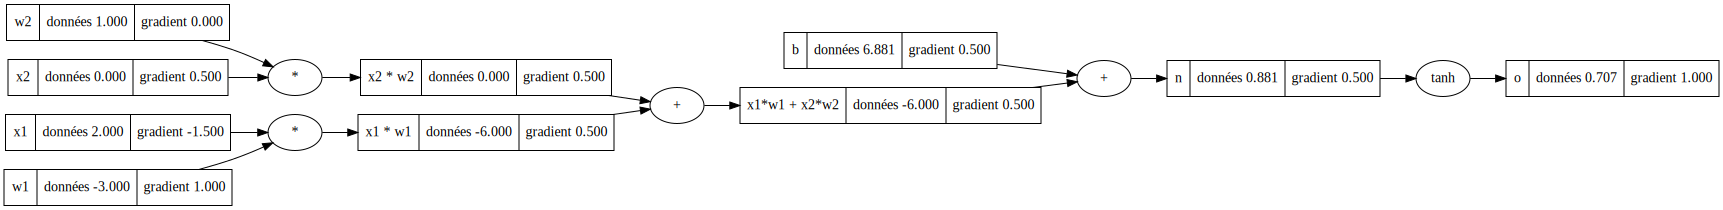

In [ ]:
# Les entrées pour le neurone
x1 = Valeur(2.0, nom = 'x1')
x2 = Valeur(0.0, nom = 'x2')

# Les poids initiales du neurone
w1 = Valeur(-3.0, nom = 'w1')
w2 = Valeur(1.0, nom = 'w2')
# Le biais
b = Valeur(6.8813735870195432, nom='b')

# Le produit scalaire
x1w1 = x1*w1;  x1w1.nom = 'x1 * w1'
x2w2 = x2*w2;  x2w2.nom = 'x2 * w2'
x1w1x2w2 = x1w1 + x2w2;  x1w1x2w2.nom='x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.nom = 'n'
o = n.tanh(); o.nom = 'o'; o.racine = True
o.calcule_grad()
dessine_graphe(o)

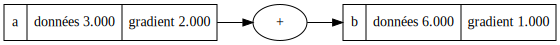

In [ ]:
a = Valeur(3.0, nom='a')
b = a + a   ; b.nom = 'b'; b.racine = True
b.calcule_grad()
dessine_graphe(b)

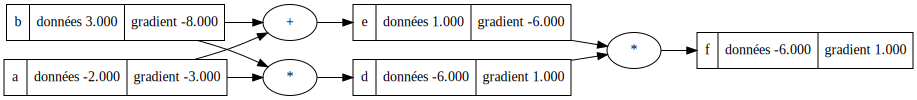

In [ ]:
a = Valeur(-2.0, nom='a')
b = Valeur(3.0, nom='b')
d = a * b    ; d.nom = 'd'
e = a + b    ; e.nom = 'e'
f = d * e    ; f.nom = 'f'; f.racine = True

f.calcule_grad()

dessine_graphe(f)

In [ ]:
import torch


x1 = torch.Tensor([2.0]).double()                ; x1.requires_grad = True
x2 = torch.Tensor([0.0]).double()                ; x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double()               ; w1.requires_grad = True
w2 = torch.Tensor([1.0]).double()                ; w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double()  ; b.requires_grad = True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()


print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())

0.7071066904050358
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737


In [ ]:
class Neurone:
  def __init__(self, nin) -> None:
     self.w = [Valeur(np.random.uniform(-1,1)) for _ in range(nin)]
     self.b = Valeur(np.random.uniform(-1,1))

  def __call__(self, x):
     act = sum((wi * xi for wi, xi in zip(self.w, x)), self.b)
     retour = act.tanh()
     return retour

  def paramètres(self):
    return self.w + [self.b]

class Couche:

  def __init__(self, nin, nout) -> None:
     self.neurones = [Neurone(nin) for _ in range(nout)]

  def __call__(self, x):
     retours = [n(x) for n in self.neurones]
     return retours[0] if len(retours) == 1 else retours
  def paramètres(self):
    return [p for neurone in self.neurones for p in neurone.paramètres()]
class MLP:

  def __init__(self, nin, nouts):
    sz = [nin] + nouts
    self.couches = [Couche(sz[i], sz[i+1]) for i in range(len(nouts))]

  def __call__(self,x):
    for couche in self.couches:
      x = couche(x)
    return x

  def paramètres(self):
    return [p for couche in self.couches for p in couche.paramètres()]



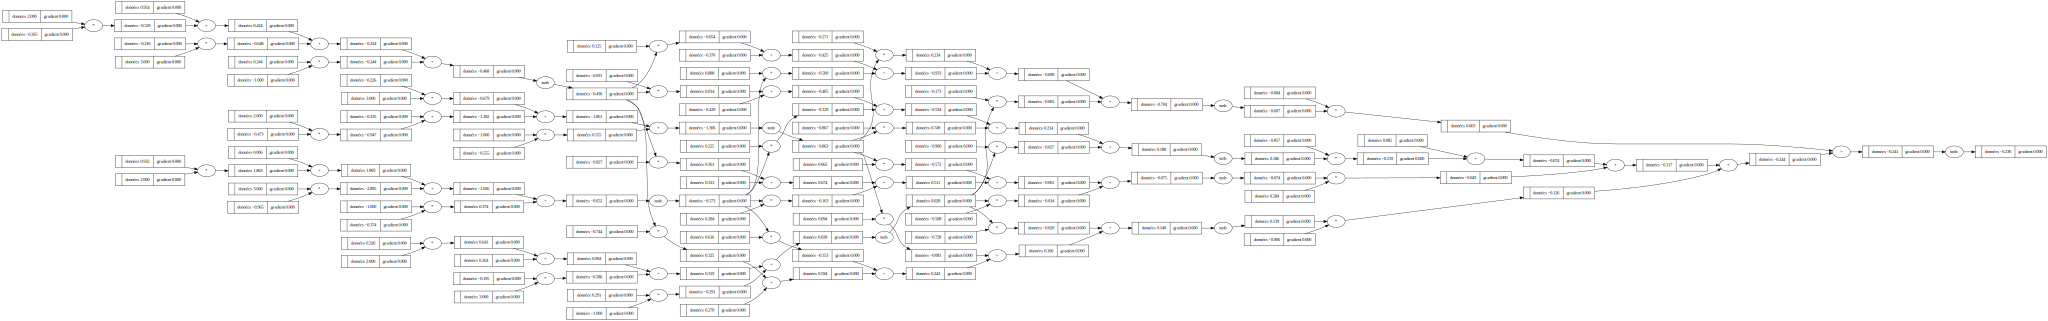

In [ ]:
x = [2.0, 3.0, -1.0]
n = MLP(3, [4, 4, 1])
n(x)
dessine_graphe(n(x))

In [ ]:
xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0]

ypred = [n(x) for x in xs]
ypred

[Valeur(données = -0.2363784423327832),
 Valeur(données = 0.09415022118239376),
 Valeur(données = 0.5245530423581262),
 Valeur(données = -0.024622000735801827)]

In [ ]:
perte_initiale = sum([(vrai_y - y_sortie)**2 for vrai_y, y_sortie in zip(ys, ypred)])
perte_initiale

Valeur(données = 6.099908582533976)

In [ ]:
for i in range(100):
  # Passage avant
  ypred = [n(x) for x in xs]
  perte = sum([(vrai_y - y_sortie)**2 for vrai_y, y_sortie in zip(ys, ypred)])

  # Passage arrière
  for p in n.paramètres():
    p.grad = 0.0
  perte.racine = True
  perte.calcule_grad()

  # Mise à jour des paramètres
  for p in n.paramètres():
    p.données += -0.1 * p.grad

  print(i, perte.données)




0 6.099908582533976
1 2.098372335893482
2 1.6526581123667352
3 2.873020038471313
4 0.08479995032464072
5 0.05228957870931686
6 0.039006628896162444
7 0.031543488658103344
8 0.026707734258508194
9 0.023298973054102966
10 0.020756596580100973
11 0.018781570480552515
12 0.017199129404437807
13 0.015900037683885322
14 0.014812394851786901
15 0.013886886722251805
16 0.013088534626070195
17 0.012391823859409928
18 0.011777696595394077
19 0.011231625126095733
20 0.01074233743687691
21 0.010300950808844049
22 0.009900368544783095
23 0.009534850961896123
24 0.009199704550531134
25 0.00889105295327293
26 0.008605665669907876
27 0.008340828182665478
28 0.008094242259983571
29 0.007863948556390762
30 0.007648265895937343
31 0.0074457431861752535
32 0.007255120997799225
33 0.007075300615025615
34 0.006905318913766137
35 0.006744327825163525
36 0.006591577435933645
37 0.006446401994857485
38 0.006308208257907567
39 0.006176465727760107
40 0.0060506984373775805
41 0.005930477999509458
42 0.0058154176

In [ ]:
ypred = [n(x) for x in xs]
ypred

[Valeur(données = 0.9820734033429451),
 Valeur(données = -0.9873367028042299),
 Valeur(données = -0.9610062786049933),
 Valeur(données = 0.9715203348366576)]